In [57]:
#!pip install optuna
#!pip install jupyterlab-optuna
#!pip install optuna-fast-fanova gunicorn
#!pip install imbalanced-learn

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt


In [59]:
df = pd.read_csv("./Data/diabetes.csv", sep = ",")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# EDA

In [60]:
#Verify that all columns have numeric types
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [61]:
#Check the target variable label values
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [62]:
#Get the summary sttistics for all the columns
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


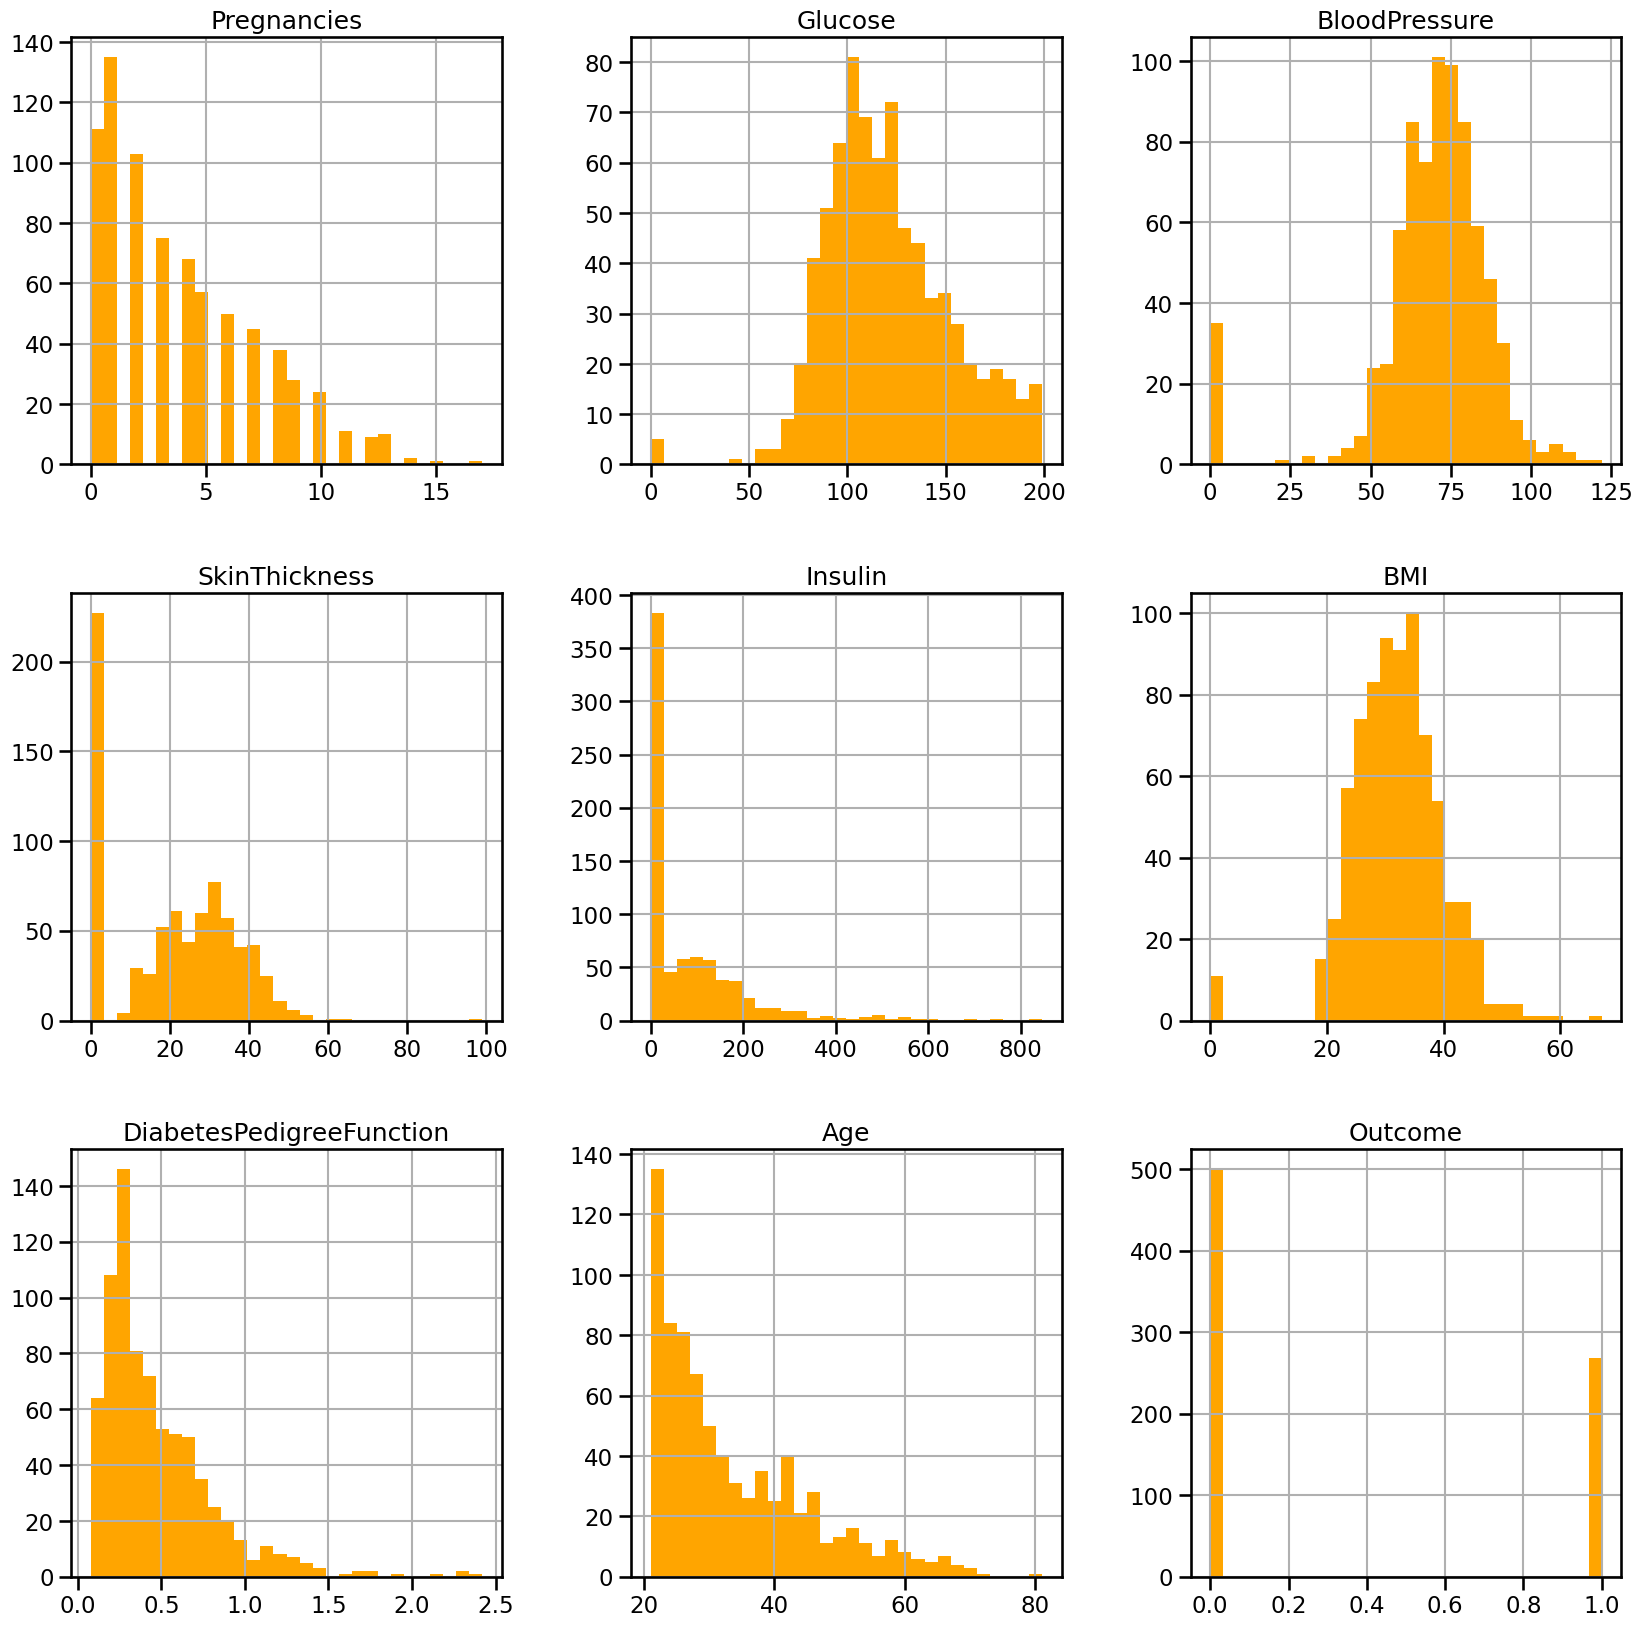

In [63]:
df.hist(bins = 30, figsize = (20, 20), color = 'orange')

plt.show()

Insights from the histograms:

* There are more young study participants.
* Similarly, zero values for skin thickness, glucose, insulin, blood presure, and bmi indicate missing measurements. A glucose level of zero would mean the patient is in a coma or worse.
* There are about twice as many patients without diabetes (outcome = 0) than with diabetes (outcome = 1) Which means we are dealing with an imbalanced target set.
* There are significantly more missing insulin measurements than glucose and since the two values are often measured simultaneously we can make the asumption that the missing glucose values were never measured.   

In [64]:
print(df[df['Glucose'] == 0].shape[0])
print(df[df['Insulin'] == 0].shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BMI"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BloodPressure"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BMI"] == 0) & (df["Insulin"] == 0) & (df["BloodPressure"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Outcome"] == 1)]).shape[0])
print(pd.DataFrame(df[(df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0])

5
374
4
10
35
7
2
2
138


* For the two cases where the outcone is positive but the glucose and insulin measurements are missing, a good reasonable value to impute is the mean between the 75th percentile and the maximum value (based on CDC - https://www.cdc.gov/diabetes/managing/manage-blood-sugar.html).
* For missing inslulin levels it's a little more complicated as it is not clearly defined what constitudes a normal level and it might be dependent on BMI and other factors. On the other hand, removing 374 records (138 of which  coresspond to the positive class) would not be practical, as the dataset is imbalanced and not very big as it is.     

In [65]:
print(df[df["Outcome"] == 0]["Insulin"].describe())

print()

print(df[df["Outcome"] == 1]["Insulin"].describe())

print()

print(df["Insulin"].describe())

print()

print(np.median(df[(df["Outcome"] == 1) & (df["Insulin"] != 0)]["Insulin"]))

count    500.000000
mean      68.792000
std       98.865289
min        0.000000
25%        0.000000
50%       39.000000
75%      105.000000
max      744.000000
Name: Insulin, dtype: float64

count    268.000000
mean     100.335821
std      138.689125
min        0.000000
25%        0.000000
50%        0.000000
75%      167.250000
max      846.000000
Name: Insulin, dtype: float64

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64

169.5


<Axes: >

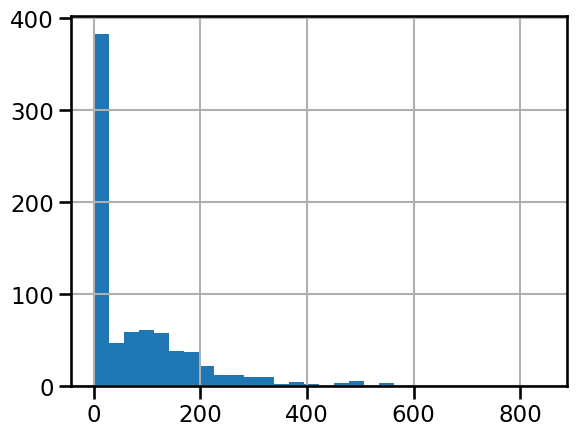

In [66]:
df["Insulin"].hist(bins = 30)

In [67]:
import numpy as np

df.loc[(df["Outcome"] == 1) & (df["Insulin"] == 0), "Insulin"] = int(np.mean(df["Insulin"]))

df.loc[(df["Outcome"] == 0) & (df["Insulin"] == 0), "Insulin"] = int(np.median(df["Insulin"]))


print(df[df["Outcome"] == 0]["Insulin"].describe())

print()

print(df[df["Outcome"] == 1]["Insulin"].describe())

print()

print(df["Insulin"].describe())

print()

print(np.median(df[df["Outcome"] == 1]["Insulin"]))



count    500.000000
mean     106.080000
std       78.691208
min       15.000000
25%       79.000000
50%       79.000000
75%      105.000000
max      744.000000
Name: Insulin, dtype: float64

count    268.000000
mean     141.014925
std      112.274909
min       14.000000
25%       79.000000
50%       79.000000
75%      167.250000
max      846.000000
Name: Insulin, dtype: float64

count    768.000000
mean     118.270833
std       93.243829
min       14.000000
25%       79.000000
50%       79.000000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64

79.0


<Axes: >

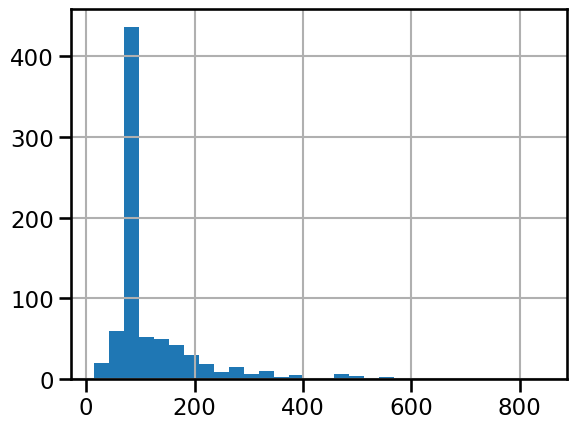

In [68]:
df["Insulin"].hist(bins = 30)

In [69]:
print(df[df['Glucose'] == 0].shape[0])
print(df[df['Insulin'] == 0].shape[0])
print(df[df['BMI'] == 0].shape[0])
print(df[df['BloodPressure'] == 0].shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BMI"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BloodPressure"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BMI"] == 0) & (df["Insulin"] == 0) & (df["BloodPressure"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Outcome"] == 1)]).shape[0])
print(pd.DataFrame(df[(df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0])

5
0
11
35
0
0
0
0
0
2
0


In [70]:
print(df[df["Outcome"] == 0]["BMI"].describe())

print()

print(df[df["Outcome"] == 1]["BMI"].describe())

print()

print(df["BMI"].describe())

print()

print(df[df["Outcome"] == 0]["BloodPressure"].describe())

print()

print(df[df["Outcome"] == 1]["BloodPressure"].describe())

print()

print(df["BloodPressure"].describe())

print()


count    500.000000
mean      30.304200
std        7.689855
min        0.000000
25%       25.400000
50%       30.050000
75%       35.300000
max       57.300000
Name: BMI, dtype: float64

count    268.000000
mean      35.142537
std        7.262967
min        0.000000
25%       30.800000
50%       34.250000
75%       38.775000
max       67.100000
Name: BMI, dtype: float64

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

count    500.000000
mean      68.184000
std       18.063075
min        0.000000
25%       62.000000
50%       70.000000
75%       78.000000
max      122.000000
Name: BloodPressure, dtype: float64

count    268.000000
mean      70.824627
std       21.491812
min        0.000000
25%       66.000000
50%       74.000000
75%       82.000000
max      114.000000
Name: BloodPressure, dtype: float64

count    768.000000
mean      69.105469
std  

In [71]:
df.loc[(df["Outcome"] == 1) & (df["BMI"] == 0), "BMI"] = np.mean(df["BMI"][df["Outcome"] == 1])

df.loc[(df["Outcome"] == 0) & (df["BMI"] == 0), "BMI"] = np.mean(df["BMI"][df["Outcome"] == 0])

df.loc[(df["Outcome"] == 1) & (df["BloodPressure"] == 0), "BloodPressure"] = int(np.mean(df["BloodPressure"][df["Outcome"] == 1]))

df.loc[(df["Outcome"] == 0) & (df["BloodPressure"] == 0), "BloodPressure"] = int(np.mean(df["BloodPressure"][df["Outcome"] == 0]))

print(df[df["Outcome"] == 0]["BMI"].describe())

print()

print(df[df["Outcome"] == 1]["BMI"].describe())

print()

print(df["BMI"].describe())

print()

print(df[df["Outcome"] == 0]["BloodPressure"].describe())

print()

print(df[df["Outcome"] == 1]["BloodPressure"].describe())

print()

print(df["BloodPressure"].describe())

print()


count    500.000000
mean      30.849676
std        6.501723
min       18.200000
25%       25.750000
50%       30.304200
75%       35.300000
max       57.300000
Name: BMI, dtype: float64

count    268.000000
mean      35.404795
std        6.590200
min       22.900000
25%       30.900000
50%       34.300000
75%       38.775000
max       67.100000
Name: BMI, dtype: float64

count    768.000000
mean      32.439222
std        6.880449
min       18.200000
25%       27.500000
50%       32.050000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

count    500.000000
mean      70.768000
std       11.940155
min       24.000000
25%       63.500000
50%       70.000000
75%       78.000000
max      122.000000
Name: BloodPressure, dtype: float64

count    268.000000
mean      75.003731
std       11.992350
min       30.000000
25%       68.000000
50%       74.000000
75%       82.000000
max      114.000000
Name: BloodPressure, dtype: float64

count    768.000000
mean      72.246094
std  

In [72]:
print(df[df['Glucose'] == 0].shape[0])
print(df[df['Insulin'] == 0].shape[0])
print(df[df['BMI'] == 0].shape[0])
print(df[df['BloodPressure'] == 0].shape[0])
print(df[df['SkinThickness'] == 0].shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BMI"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BloodPressure"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BMI"] == 0) & (df["Insulin"] == 0) & (df["BloodPressure"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Outcome"] == 1)]).shape[0])
print(pd.DataFrame(df[(df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0])

5
0
0
0
227
0
0
0
0
0
2
0


In [73]:
df.loc[(df["Outcome"] == 1) & (df["Glucose"] == 0), "Glucose"] = int(np.mean(df["Glucose"][df["Outcome"] == 1]))

df.loc[(df["Outcome"] == 0) & (df["Glucose"] == 0), "Glucose"] = int(np.mean(df["Glucose"][df["Outcome"] == 0]))

df.loc[(df["Outcome"] == 1) & (df["SkinThickness"] == 0), "SkinThickness"] = int(np.mean(df["SkinThickness"][df["Outcome"] == 1]))

df.loc[(df["Outcome"] == 0) & (df["SkinThickness"] == 0), "SkinThickness"] = int(np.mean(df["SkinThickness"][df["Outcome"] == 0]))

print(df[df['Glucose'] == 0].shape[0])
print(df[df['Insulin'] == 0].shape[0])
print(df[df['BMI'] == 0].shape[0])
print(df[df['BloodPressure'] == 0].shape[0])
print(df[df['SkinThickness'] == 0].shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BMI"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BloodPressure"] == 0) & (df["Insulin"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["BMI"] == 0) & (df["Insulin"] == 0) & (df["BloodPressure"] == 0)]).shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0])
print(pd.DataFrame(df[(df["Glucose"] == 0) & (df["Outcome"] == 1)]).shape[0])
print(pd.DataFrame(df[(df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0])

0
0
0
0
0
0
0
0
0
0
0
0


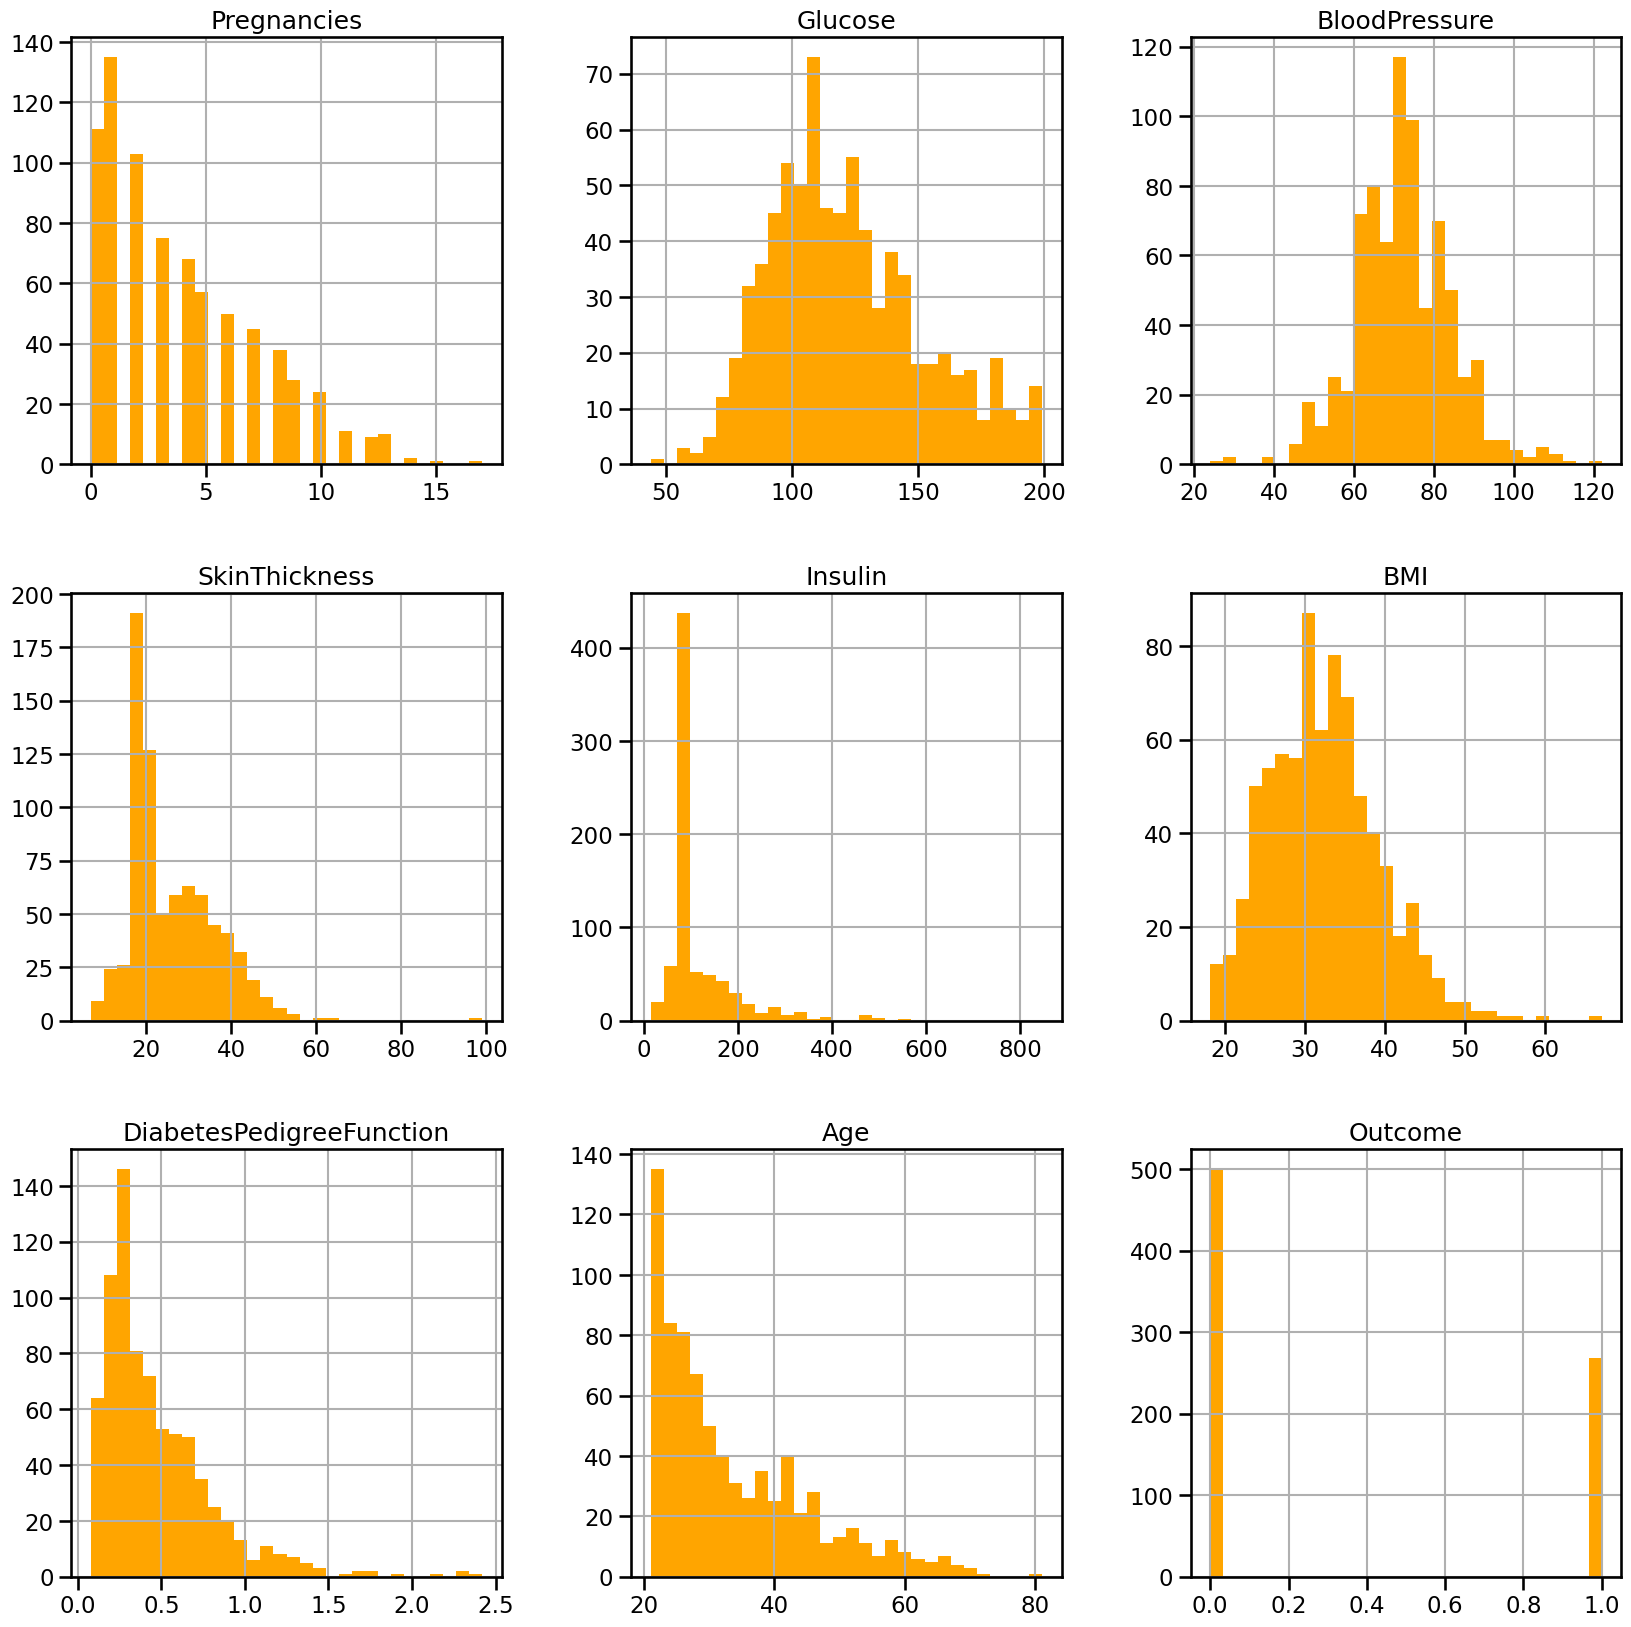

In [74]:
df.hist(bins = 30, figsize = (20, 20), color = 'orange')

plt.show()

In [75]:
# Check the number of records left after cleaning
df.shape

(768, 9)

In [76]:
# Create a correlation matrix

corr_matrix = df.corr()

corr_matrix

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129988,0.209273,0.015304,-0.018780,0.024268,-0.033523,0.544341,0.221898
Glucose,0.129988,1.000000,0.223246,0.180478,0.395919,0.235864,0.138227,0.268716,0.495950
BloodPressure,0.209273,0.223246,1.000000,0.135966,0.010625,0.284565,0.000991,0.327012,0.166684
SkinThickness,0.015304,0.180478,0.135966,1.000000,0.243303,0.547892,0.158611,0.025308,0.217639
Insulin,-0.018780,0.395919,0.010625,0.243303,1.000000,0.190455,0.158243,0.037676,0.178696
BMI,0.024268,0.235864,0.284565,0.547892,0.190455,1.000000,0.152558,0.027929,0.315760
DiabetesPedigreeFunction,-0.033523,0.138227,0.000991,0.158611,0.158243,0.152558,1.000000,0.033561,0.173844
Age,0.544341,0.268716,0.327012,0.025308,0.037676,0.027929,0.033561,1.000000,0.238356
Outcome,0.221898,0.495950,0.166684,0.217639,0.178696,0.315760,0.173844,0.238356,1.000000


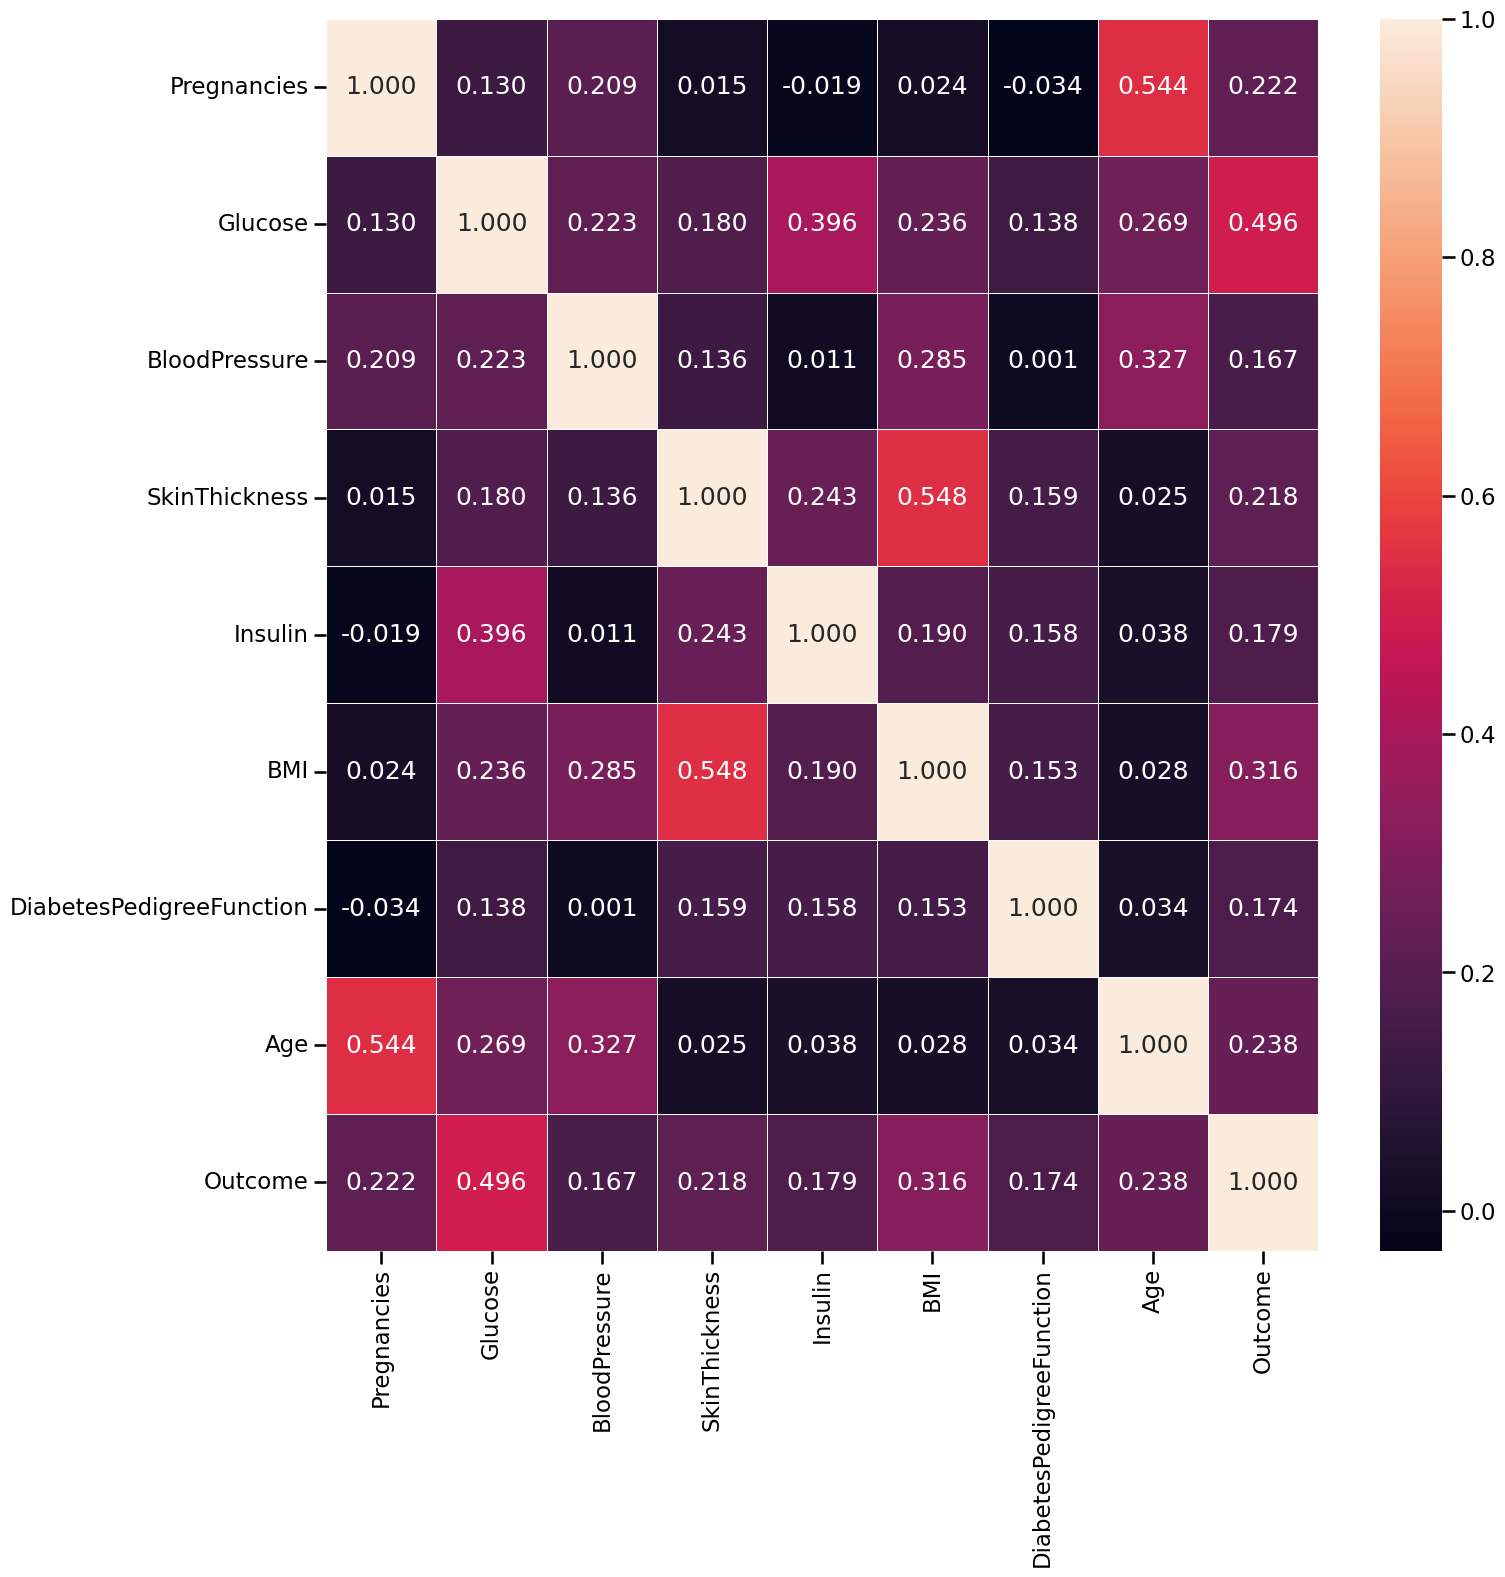

In [77]:
# Plot the correlation matrix
sns.set_context('talk')

plt.figure(figsize = (16, 16))

_ = sns.heatmap(corr_matrix, annot = True, fmt = ".3f", linewidths = .5)

plt.show()

fig = _.get_figure()

fig.savefig('img/corr_mat_diabetes.png')

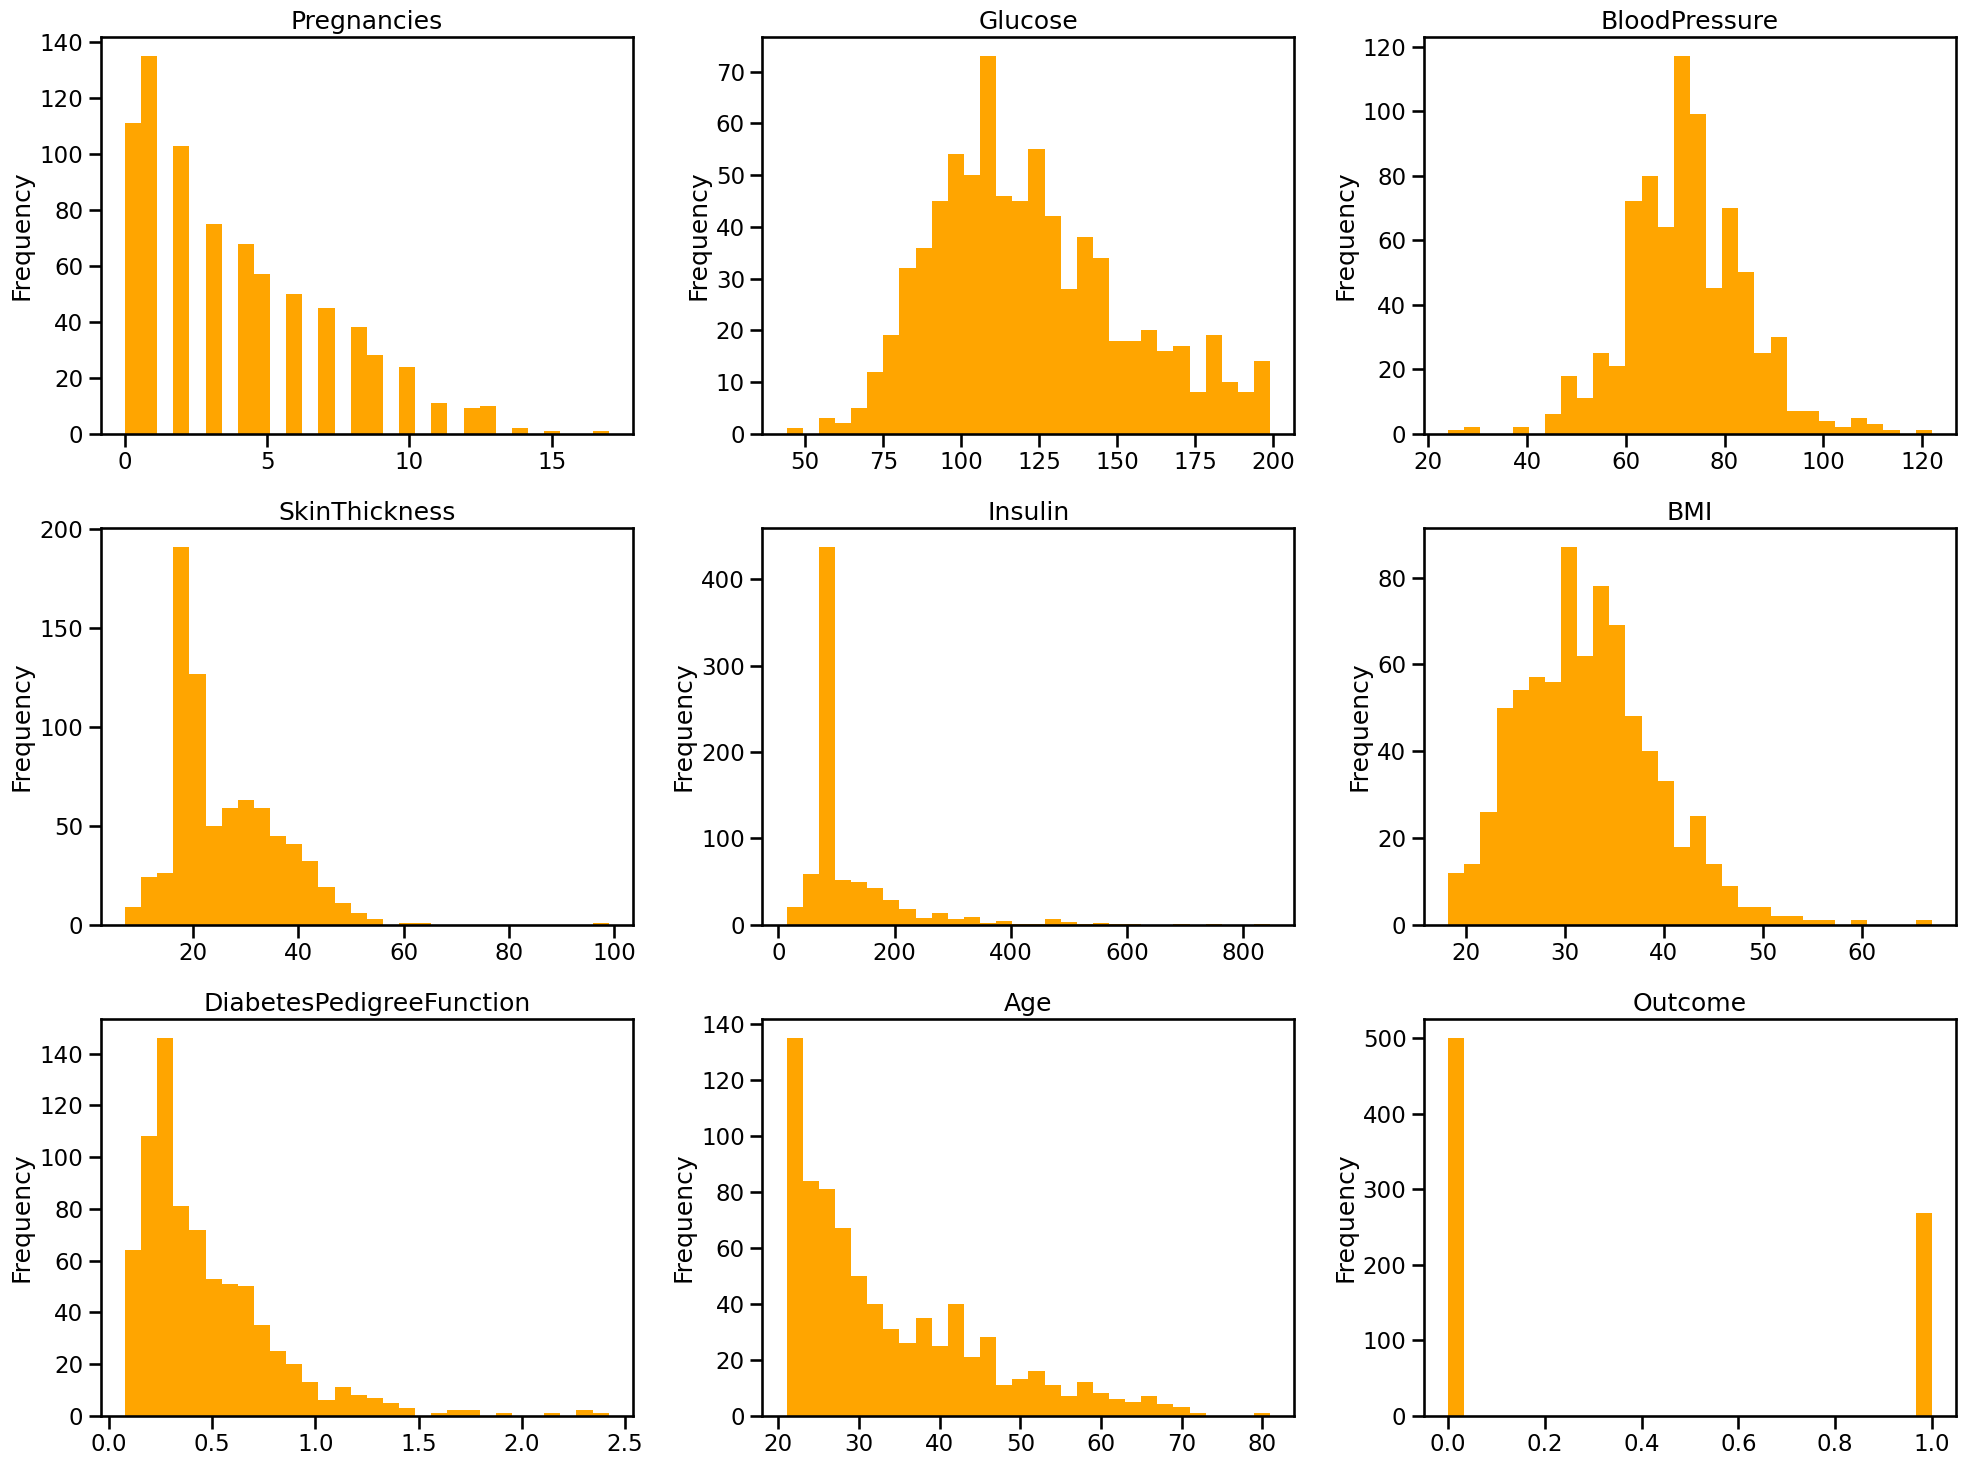

In [78]:
## Export the histograms to an image file
# Determine the number of rows and columns for subplots
num_cols = 3
num_rows = -(-len(df.columns) // num_cols)  # Ceiling division to ensure enough rows

# Create a figure and axes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histogram for each column
for i, (col, ax) in enumerate(zip(df.columns, axes)):
    df[col].plot(kind='hist', bins=30, ax=ax, color='orange')
    ax.set_title(col)

# Remove any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('img/histograms_diabetes.png')

# Show the plot
plt.show()

There are significant correlations between BMI and skin thickness, skin thickness and insulin, glucose and insulin, glucose and outcome, blood presure and age and blood presure and bmi. 

# Split the data into training and test sets

In [79]:
# split the dataframe into target and features

y = df["Outcome"] # target
X = df.drop(columns = ["Outcome"]) # features

# Verify that the split was performed correctly
print(X.shape)
print(y.shape)

(768, 8)
(768,)


In [80]:
from collections import Counter

counter = Counter(y)
print(counter)

Counter({0: 500, 1: 268})


In [81]:
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.866


In [82]:
# split the labels and features into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21, stratify = y)

# Verify that the split was performed correctly
print('Training set')
print(X_train.shape)
print(y_train.shape)
print()
print('Testing set')
print(X_test.shape)
print(y_test.shape)
print()

Training set
(537, 8)
(537,)

Testing set
(231, 8)
(231,)



In [83]:
# Verify that the index has been shuffled
print(X.index)
print()
print(X_train.index)

RangeIndex(start=0, stop=768, step=1)

Index([452, 338, 294, 376, 702, 250, 329, 528, 309, 744,
       ...
       399, 758, 570, 761, 739, 319, 443, 508, 470, 727],
      dtype='int64', length=537)


In [84]:
from sklearn.preprocessing import RobustScaler

# Create a StandardScaler object
scaler = RobustScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data (using the same scaling parameters as the training data)
X_test_scaled = scaler.transform(X_test)

display(pd.DataFrame(X_train_scaled).head())

print()

display(X_train.head())

,0,1,2,3,4,5,6,7
0,-0.6,-0.595238,-0.266667,0.692308,2.673469,0.836957,0.035135,-0.294118
1,1.2,0.857143,0.400000,0.846154,1.877551,0.217391,1.418919,0.176471
2,-0.6,1.071429,-1.466667,-0.307692,0.000000,-1.119565,-0.308108,2.058824
3,-0.6,-0.428571,0.666667,-0.615385,0.102041,-0.760870,-0.186486,-0.470588
4,-0.4,1.238095,1.066667,0.461538,0.000000,0.304348,1.451351,1.294118


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
452,0,91,68,32,210,39.9,0.381,25
338,9,152,78,34,171,34.2,0.893,33
294,0,161,50,19,79,21.9,0.254,65
376,0,98,82,15,84,25.2,0.299,22
702,1,168,88,29,79,35.0,0.905,52


# Train an XGBoost Classifier in scikit-learn

In [85]:
# import the classifier

from xgboost import XGBClassifier

In [86]:
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'error', 
                               learning_rate = 0.1,
                               max_depth = 8,
                               alpha = 25,
                               n_estimators = 100,
                               scale_pos_weight=1.908
                               )

xgb_classifier.fit(X_train, y_train)

XGBClassifier(alpha=25, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

# Test the model

In [87]:
# predict the performance score of the trained model using the testing dataset

result = xgb_classifier.score(X_test, y_test)
print("Accuracy: {}".format(result))

Accuracy: 0.7922077922077922


In [88]:
# make predictions on the test data

y_predict = xgb_classifier.predict(X_test)
y_predict

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0])

In [89]:
# print the performance report

from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       150
           1       0.68      0.77      0.72        81

    accuracy                           0.79       231
   macro avg       0.77      0.79      0.78       231
weighted avg       0.80      0.79      0.79       231



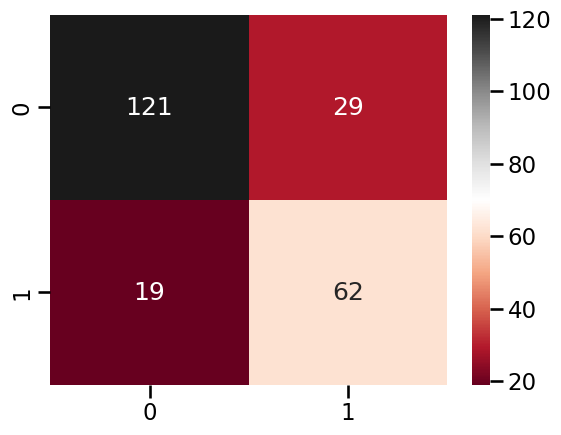

In [90]:
# print the confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)

sns.set_context('talk')

sns.heatmap(cm, fmt = 'd', annot = True, cmap = 'RdGy')

plt.savefig('img/conf_mat_diabetes.png')


## Re-train the model on the scaled set

Accuracy: 0.7922077922077922
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       150
           1       0.68      0.77      0.72        81

    accuracy                           0.79       231
   macro avg       0.77      0.79      0.78       231
weighted avg       0.80      0.79      0.79       231



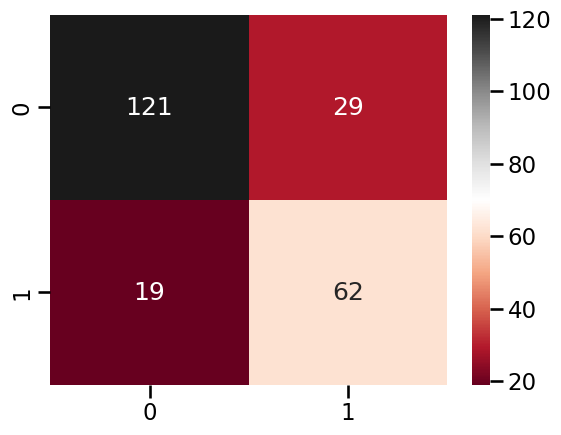

In [91]:
xgb_classifier.fit(X_train_scaled, y_train)

# predict the performance score of the trained model using the testing dataset

result = xgb_classifier.score(X_test_scaled, y_test)
print("Accuracy: {}".format(result))

# make predictions on the test data
y_predict = xgb_classifier.predict(X_test_scaled)

# print the performance report

from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict))

# print the confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)

sns.set_context('talk')

sns.heatmap(cm, fmt = 'd', annot = True, cmap = 'RdGy')

plt.savefig('img/conf_mat_diabetes.png')

In [92]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score

In [93]:
X_train = X_train.drop(columns = "DiabetesPedigreeFunction") 
X_test = X_test.drop(columns = "DiabetesPedigreeFunction") 

In [94]:
selected_features = SelectKBest(chi2, k = 6).fit(X_train, y_train)

print('Score List: ', selected_features.scores_)
print()
print('Feature list: ', X_train.columns)

Score List:  [  72.39269054 1055.80978301   34.35633516  105.9431129  1212.0746309
   87.40502948  122.69623688]

Feature list:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Age'],
      dtype='object')



Accuracy: 0.8441558441558441

Accuracy is:  0.8441558441558441



,0,1,2,3,4,5
0,0.0,91.0,32.0,210.0,39.9,25.0
1,9.0,152.0,34.0,171.0,34.2,33.0
2,0.0,161.0,19.0,79.0,21.9,65.0
3,0.0,98.0,15.0,84.0,25.2,22.0
4,1.0,168.0,29.0,79.0,35.0,52.0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age
452,0,91,68,32,210,39.9,25
338,9,152,78,34,171,34.2,33
294,0,161,50,19,79,21.9,65
376,0,98,82,15,84,25.2,22
702,1,168,88,29,79,35.0,52


<Axes: >

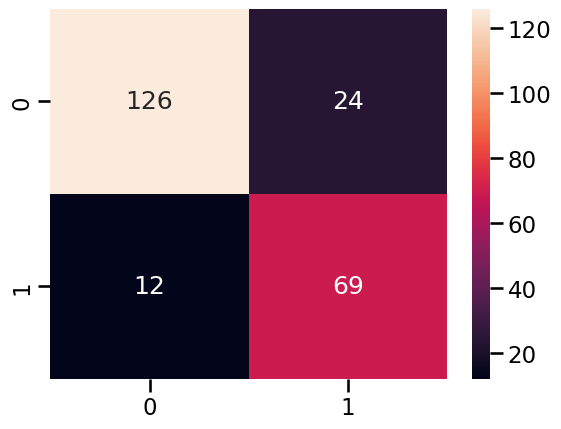

In [95]:
X_train_2 = selected_features.transform(X_train)

X_test_2 = selected_features.transform(X_test)

evalset = [(X_train_2, y_train), (X_test_2, y_test)]

xgb_classifier_2 = XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'logloss', 
                                 learning_rate = 0.02,
                                 max_depth = 8,
                                 alpha = 17,
                                 n_estimators = 230,                
                                 min_child_weight = 1,                                 
                                 scale_pos_weight = 1.908,
                                 use_label_encoder = False,
                                 seed = 21).fit(X_train_2, y_train, eval_set = evalset, verbose = 0)

result2 = xgb_classifier_2.score(X_test_2, y_test)
print()
print("Accuracy: {}".format(result2))

print()
print('Accuracy is: ', accuracy_score(y_test, xgb_classifier_2.predict(X_test_2)))
print()

display(pd.DataFrame(X_train_2).head())
display(X_train.head())

cm_2 = confusion_matrix(y_test, xgb_classifier_2.predict(X_test_2))

sns.heatmap(cm_2, annot = True, fmt = 'd')

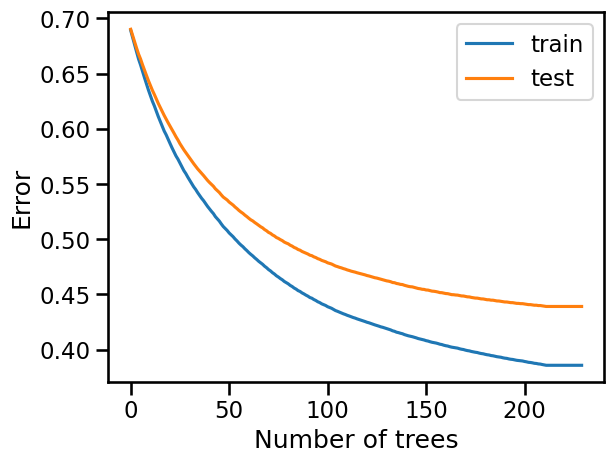

In [96]:
results = xgb_classifier_2.evals_result()

plt.plot(results['validation_0']['logloss'], label = 'train')
plt.plot(results['validation_1']['logloss'], label = 'test')

plt.xlabel('Number of trees')
plt.ylabel('Error')

plt.legend()

plt.show()

In [97]:
print(result2)

0.8441558441558441


In [98]:
# stratified k-fold cross validation evaluation of xgboost model
import xgboost
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# CV model
model = xgboost.XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'auc', 
                                 learning_rate = 0.0045,
                                 max_depth = 10,
                                 alpha = 17,
                                 n_estimators = 200,                
                                 min_child_weight = 1,                                 
                                 scale_pos_weight = 1.853,
                                 use_label_encoder = False,
                                 seed = 21)
kfold = StratifiedKFold(n_splits=15, shuffle = True, random_state=21)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 81.54% (7.80%)


In [99]:
xgb_classifier_3 = XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'auc', 
                                 learning_rate = 0.0045,
                                 max_depth = 10,
                                 alpha = 17,
                                 n_estimators = 200,                
                                 min_child_weight = 1,                                 
                                 scale_pos_weight = 1.853,
                                 use_label_encoder = False,
                                 seed = 21
                               )

xgb_classifier_3.fit(X_train, y_train)

# predict the performance score of the trained model using the testing dataset

result3 = xgb_classifier_3.score(X_test, y_test)

y_pred_3 = xgb_classifier_3.predict(X_test)


              precision    recall  f1-score   support

           0       0.87      0.89      0.88       150
           1       0.78      0.75      0.77        81

    accuracy                           0.84       231
   macro avg       0.83      0.82      0.82       231
weighted avg       0.84      0.84      0.84       231


Accuracy: 0.8398

Log Loss: 0.5424

ROC AUC: 0.8874



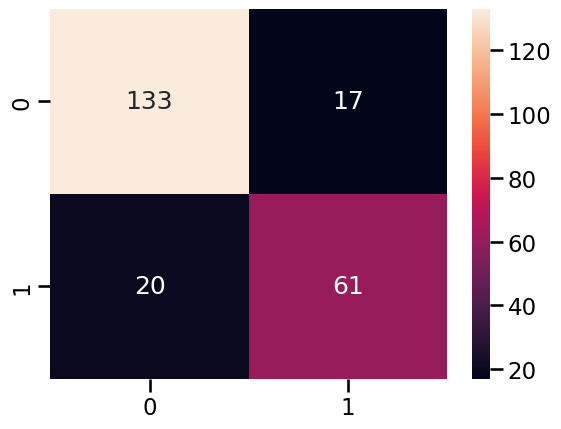

In [100]:
cm_3 = confusion_matrix(y_test, y_pred_3)

sns.heatmap(cm_3, annot = True, fmt = 'd')

print()
print(classification_report(y_test, y_pred_3))

print()
print("Accuracy: {}".format(round(result3, 4)))

print()
# Calculate log loss
log_loss_3 = log_loss(y_test, xgb_classifier_3.predict_proba(X_test))

print("Log Loss: {}".format(round(log_loss_3, 4)))

print()

# Calculate ROC AUC
roc_auc_3 = roc_auc_score(y_test, xgb_classifier_3.predict_proba(X_test)[:, 1])

print("ROC AUC: {}".format(round(roc_auc_3, 4)))

print()

In [101]:
df_less_features = df.drop(columns = ["Pregnancies", "DiabetesPedigreeFunction"])

# split data into X and y
y_less = df_less_features["Outcome"] # target
X_less = df_less_features.drop(columns = ["Outcome"]) # features

X_less_train, X_less_test, y_less_train, y_less_test = train_test_split(X_less, y_less, test_size = 0.23, random_state = 21, stratify = y)

selected_features = SelectKBest(chi2, k = 5).fit(X_less_train, y_less_train)

print()
print('Score List: ', selected_features.scores_)
print()
print('Feature list: ', X_train.columns)
print()
X_train_4 = selected_features.transform(X_less_train)

X_test_4 = selected_features.transform(X_less_test)

#Compare the transformed and original array
print("Reduced features array")

display(pd.DataFrame(X_train_4).head())

print()
print("Original training set")

display(pd.DataFrame(X_less_train).head())






Score List:  [1132.98333396   33.09722673  112.29426954 1341.69502225   92.85209366
  128.83147192]

Feature list:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Age'],
      dtype='object')

Reduced features array


,0,1,2,3,4
0,100.0,25.0,184.0,36.6,46.0
1,106.0,19.0,79.0,23.6,44.0
2,110.0,29.0,125.0,32.4,27.0
3,122.0,19.0,79.0,31.2,41.0
4,102.0,22.0,79.0,39.5,42.0



Original training set


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age
298,100,78,25,184,36.6,46
333,106,80,19,79,23.6,44
85,110,74,29,125,32.4,27
246,122,68,19,79,31.2,41
739,102,74,22,79,39.5,42


In [102]:
#Return the transformed arrays to a dataframe with the corresponding column names to keep consistent with the test set
X_train_4 = pd.DataFrame(X_train_4, columns = ["Glucose", "SkinThickness", "Insulin", "BMI", "Age"])
X_test_4 = pd.DataFrame(X_test_4, columns = ["Glucose", "SkinThickness", "Insulin", "BMI", "Age"])

evalset = [(X_train_4, y_less_train), (X_test_4, y_less_test)]

In [103]:
xgb_classifier_4 = XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'auc', 
                                 learning_rate = 0.0045,
                                 max_depth = 10,
                                 alpha = 17,
                                 n_estimators = 200,                
                                 min_child_weight = 1,                                 
                                 scale_pos_weight = 1.853,
                                 use_label_encoder = False,
                                 seed = 21).fit(X_train_4, y_less_train, eval_set = evalset, verbose = 0)

result4 = xgb_classifier_4.score(X_test_4, y_less_test)

y_pred_4 = xgb_classifier_4.predict(X_test_4) 


              precision    recall  f1-score   support

           0       0.92      0.86      0.89       115
           1       0.77      0.85      0.81        62

    accuracy                           0.86       177
   macro avg       0.84      0.86      0.85       177
weighted avg       0.86      0.86      0.86       177


Accuracy: 0.8588

Log Loss: 0.5343

ROC AUC: 0.9012



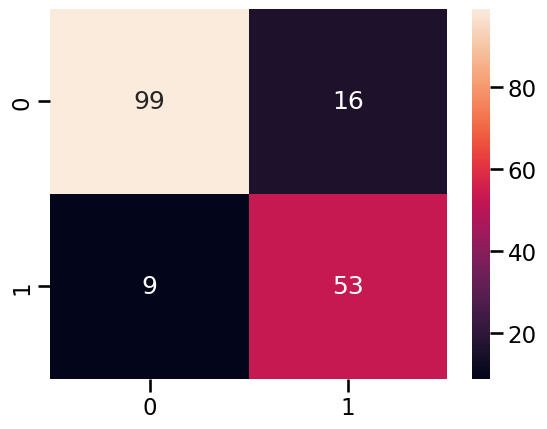

In [104]:
cm_4 = confusion_matrix(y_less_test, y_pred_4)

sns.heatmap(cm_4, annot = True, fmt = 'd')

print()
print(classification_report(y_less_test, y_pred_4))

print()
print("Accuracy: {}".format(round(result4, 4)))

print()
# Calculate log loss
log_loss_4 = log_loss(y_less_test, xgb_classifier_4.predict_proba(X_test_4))

print("Log Loss: {}".format(round(log_loss_4, 4)))

print()

# Calculate ROC AUC
roc_auc_4 = roc_auc_score(y_less_test, xgb_classifier_4.predict_proba(X_test_4)[:, 1])

print("ROC AUC: {}".format(round(roc_auc_4, 4)))

print()

In [112]:
from sklearn.model_selection import StratifiedKFold

# Create a StratifiedKFold object with 3 splits
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

X_train_4 = pd.DataFrame(X_train_4)

def strat_objective(trial):
    # Define the hyperparameter search space
    max_depth = trial.suggest_int('max_depth', 2, 15)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    scale_pos_weight = 1.853  # Use the value you calculated
    # Create the XGBClassifier with the sampled hyperparameters
    # Create the XGBClassifier with the sampled hyperparameters
    classifier = XGBClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        seed=21,
        n_jobs=-1,
    )
    
    # Perform stratified cross-validation and return the negative mean score
    scores = []
    for train_index, val_index in skf.split(X_train_4, y_less_train):
        X_train_strat, X_val = X_train_4.iloc[train_index], X_train_4.iloc[val_index]
        y_train_strat, y_val = y_less_train.iloc[train_index], y_less_train.iloc[val_index]
        classifier.fit(X_train_strat, y_train_strat)
        score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:, 1])
        scores.append(score)

    return -np.mean(scores)

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
study.optimize(strat_objective, n_trials=100)

# Print the best hyperparameters and the corresponding score
print()
print('Best hyperparameters: ', study.best_params)
print()
print('Best score: ', -study.best_value)
print()

[I 2024-04-06 01:13:43,630] A new study created in memory with name: no-name-6159f418-2124-4f38-8973-58425964bf3d
[I 2024-04-06 01:13:43,932] Trial 0 finished with value: -0.8773440029871066 and parameters: {'max_depth': 6, 'n_estimators': 204, 'learning_rate': 0.13267512963755188, 'min_child_weight': 2, 'gamma': 2.383135691738859e-06, 'subsample': 0.9132542064070416, 'colsample_bytree': 0.552353938311817, 'reg_alpha': 4.5991451306793956e-06, 'reg_lambda': 4.340122241777636e-07}. Best is trial 0 with value: -0.8773440029871066.
[I 2024-04-06 01:13:44,162] Trial 1 finished with value: -0.889384588727638 and parameters: {'max_depth': 15, 'n_estimators': 290, 'learning_rate': 0.03424676584001316, 'min_child_weight': 9, 'gamma': 1.5518854395645633e-05, 'subsample': 0.9095512080918144, 'colsample_bytree': 0.8280223833000406, 'reg_alpha': 0.0004392284277064126, 'reg_lambda': 0.2634828332926567}. Best is trial 1 with value: -0.889384588727638.
[I 2024-04-06 01:13:44,475] Trial 2 finished with

Best hyperparameters:  {'max_depth': 3, 'n_estimators': 317, 'learning_rate': 0.01430548844650642, 'min_child_weight': 5, 'gamma': 0.2065076007167739, 'subsample': 0.8415801374501213, 'colsample_bytree': 0.5518694039036027, 'reg_alpha': 3.7522765281258646e-08, 'reg_lambda': 0.0003508483191270577}
Best score:  0.9043469690285956


In [113]:
xgb_classifier_opt = XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'auc', 
                                 learning_rate = 0.01430548844650642,
                                 max_depth = 3,
                                 #alpha = 17,
                                 gamma = 0.2065076007167739,
                                 n_estimators = 317,                
                                 min_child_weight = 5,
                                 subsample = 0.8415801374501213,
                                 colsample_bytree = 0.5518694039036027,
                                 reg_alpha = 3.7522765281258646e-08,
                                 reg_lambda = 0.0003508483191270577,
                                 scale_pos_weight = 1.853,
                                 use_label_encoder = False,
                                 seed = 21).fit(X_train_4, y_less_train, eval_set = evalset, verbose = 0)

result_opt = xgb_classifier_opt.score(X_test_4, y_less_test)

y_pred_opt = xgb_classifier_opt.predict(X_test_4) 

y_pred_proba_opt = xgb_classifier_opt.predict_proba(X_test_4)


              precision    recall  f1-score   support

           0       0.90      0.85      0.88       115
           1       0.75      0.82      0.78        62

    accuracy                           0.84       177
   macro avg       0.82      0.84      0.83       177
weighted avg       0.85      0.84      0.84       177


Accuracy: 0.8418

Log Loss: 0.3776

ROC AUC: 0.9149

AUPRC: 0.8445



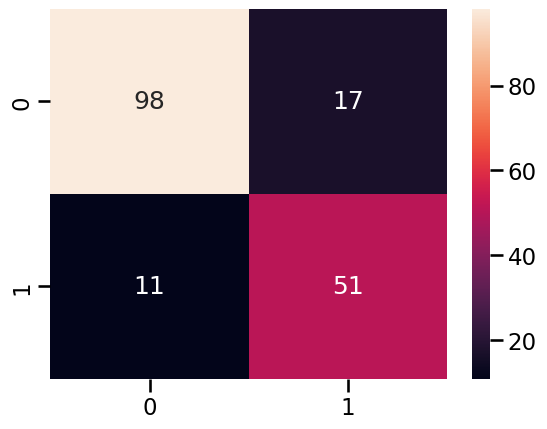

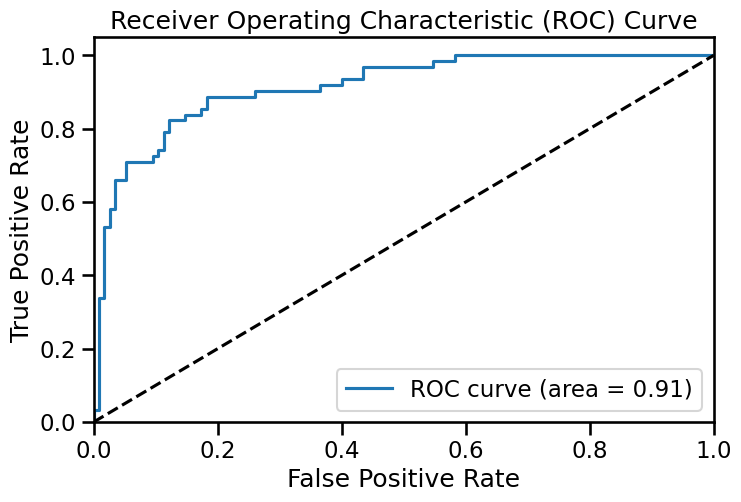

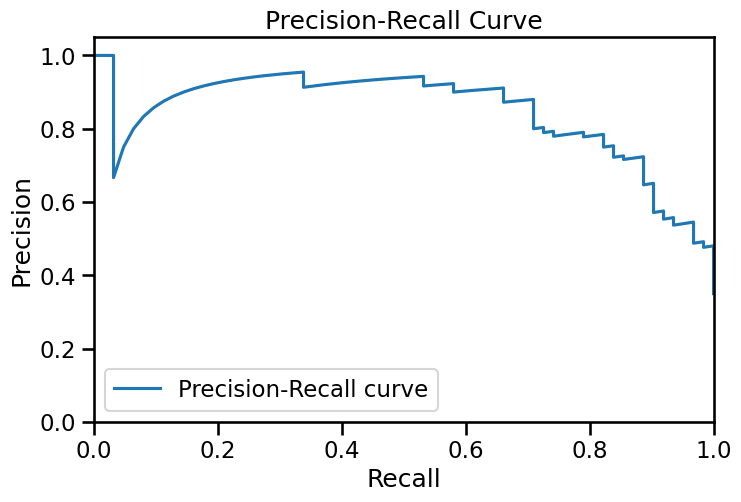

In [114]:
cm_opt = confusion_matrix(y_less_test, y_pred_opt)

sns.heatmap(cm_opt, annot = True, fmt = 'd')

print()
print(classification_report(y_less_test, y_pred_opt))

print()
print("Accuracy: {}".format(round(result_opt, 4)))

print()
# Calculate log loss
log_loss_opt = log_loss(y_less_test, y_pred_proba_opt)

print("Log Loss: {}".format(round(log_loss_opt, 4)))

print()

# Calculate ROC AUC
roc_auc_opt = roc_auc_score(y_less_test, y_pred_proba_opt[:, 1])

print("ROC AUC: {}".format(round(roc_auc_opt, 4)))

print()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_less_test, y_pred_proba_opt[:, 1])

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_less_test, y_pred_proba_opt[:, 1])

# Define recall levels for interpolation
recall_levels = np.linspace(0, 1, 100)

# Interpolate precision values for each recall level
interp_precision_opt = np.interp(recall_levels, recall[::-1], precision[::-1])

# Calculate AUPRC using the trapezoidal rule
auprc_opt = np.trapz(interp_precision_opt, recall_levels)

print("AUPRC: {}".format(round(auprc_opt, 4)))

print()

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_less_test, y_pred_proba_opt[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('pr_curve.png', dpi=300, bbox_inches='tight')
plt.show()


              precision    recall  f1-score   support

           0       0.91      0.86      0.88       115
           1       0.76      0.84      0.80        62

    accuracy                           0.85       177
   macro avg       0.84      0.85      0.84       177
weighted avg       0.86      0.85      0.85       177


Accuracy: 0.8531

Log Loss: 0.3775

ROC AUC: 0.9121

AUPRC: 0.8435


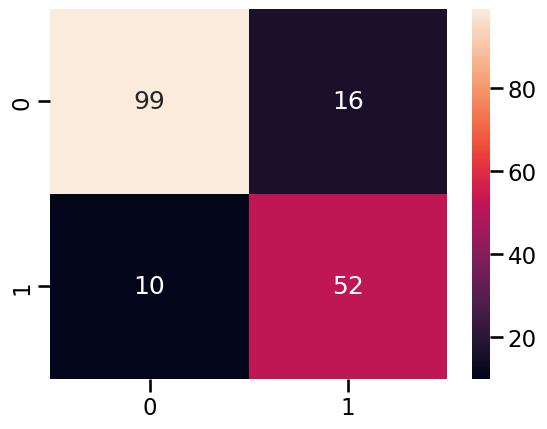

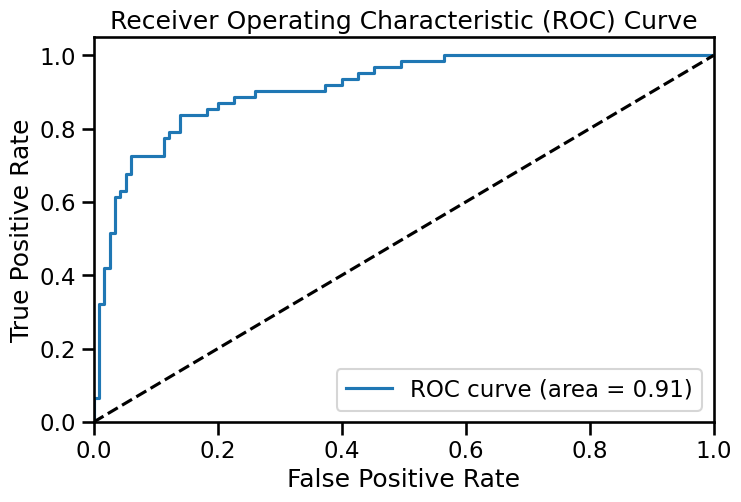

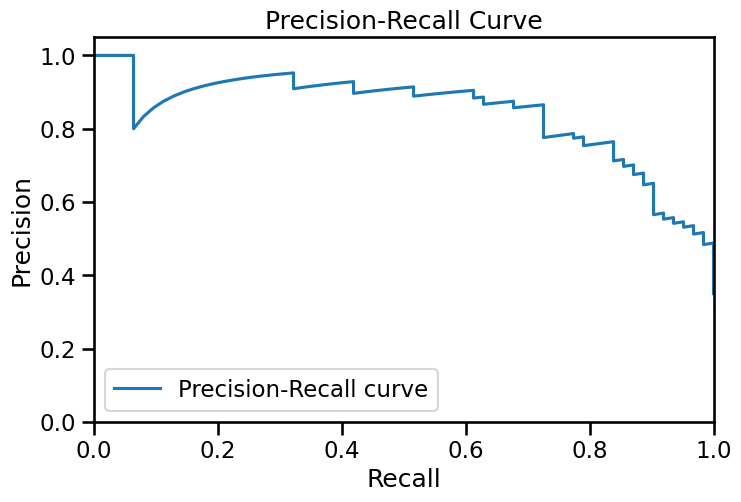

In [116]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_4, y_less_train)

evalset_resampled = [(X_resampled, y_resampled), (X_test_4, y_less_test)]

xgb_classifier_resampled = XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'auc', 
                                 learning_rate = 0.01430548844650642,
                                 max_depth = 3,
                                 #alpha = 17,
                                 gamma = 0.2065076007167739,
                                 n_estimators = 317,                
                                 min_child_weight = 5,
                                 subsample = 0.8415801374501213,
                                 colsample_bytree = 0.5518694039036027,
                                 reg_alpha = 3.7522765281258646e-08,
                                 reg_lambda = 0.0003508483191270577,
                                 #scale_pos_weight = 1.853,
                                 use_label_encoder = False,
                                 seed = 21).fit(X_resampled, y_resampled, eval_set = evalset_resampled, verbose = 0)

result_resampled = xgb_classifier_resampled.score(X_test_4, y_less_test)

y_pred_resampled = xgb_classifier_resampled.predict(X_test_4) 

y_pred_proba_resampled = xgb_classifier_resampled.predict_proba(X_test_4)

cm_resampled = confusion_matrix(y_less_test, y_pred_resampled)

sns.heatmap(cm_resampled, annot = True, fmt = 'd')

print()
print(classification_report(y_less_test, y_pred_resampled))

print()
print("Accuracy: {}".format(round(result_resampled, 4)))

print()
# Calculate log loss
log_loss_resampled = log_loss(y_less_test, y_pred_proba_resampled)

print("Log Loss: {}".format(round(log_loss_resampled, 4)))

print()

# Calculate ROC AUC
roc_auc_resampled = roc_auc_score(y_less_test, y_pred_proba_resampled[:, 1])

print("ROC AUC: {}".format(round(roc_auc_resampled, 4)))

print()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_less_test, y_pred_proba_resampled[:, 1])

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_less_test, y_pred_proba_resampled[:, 1])

# Define recall levels for interpolation
recall_levels = np.linspace(0, 1, 100)

# Interpolate precision values for each recall level
interp_precision = np.interp(recall_levels, recall[::-1], precision[::-1])

# Calculate AUPRC using the trapezoidal rule
auprc = np.trapz(interp_precision, recall_levels)

print("AUPRC: {}".format(round(auprc, 4)))

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_less_test, y_pred_proba_resampled[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('pr_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [108]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function to optimize
def objective(trial):
    # Define the hyperparameter search space
    max_depth = trial.suggest_int('max_depth', 2, 15)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    #scale_pos_weight = 1.853  # Use the value you calculated

    # Create the XGBClassifier with the sampled hyperparameters
    classifier = XGBClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        #scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        seed=21,
        n_jobs=-1,
    )

    # Perform cross-validation and return the negative mean score
    score = cross_val_score(classifier, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
    return -score.mean()

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and the corresponding score
print()
print('Best hyperparameters: ', study.best_params)
print()
print('Best score: ', -study.best_value)
print()

[I 2024-04-06 01:07:34,963] A new study created in memory with name: no-name-1272d84c-7c25-4d97-bc7a-fd3ad08a1c52
[I 2024-04-06 01:07:36,393] Trial 0 finished with value: -0.9241693371563502 and parameters: {'max_depth': 15, 'n_estimators': 192, 'learning_rate': 0.01046392881751849, 'min_child_weight': 4, 'gamma': 0.06071949170200722, 'subsample': 0.7715607717908108, 'colsample_bytree': 0.7739448657410049, 'reg_alpha': 1.0508334537304449e-08, 'reg_lambda': 0.00564042641071218}. Best is trial 0 with value: -0.9241693371563502.
[I 2024-04-06 01:07:36,593] Trial 1 finished with value: -0.9316242199359083 and parameters: {'max_depth': 4, 'n_estimators': 272, 'learning_rate': 0.05086734314024068, 'min_child_weight': 1, 'gamma': 0.10151223300842238, 'subsample': 0.5069728411625362, 'colsample_bytree': 0.7684549235228023, 'reg_alpha': 3.9995204373842657e-07, 'reg_lambda': 4.4302273254150776e-07}. Best is trial 1 with value: -0.9316242199359083.
[I 2024-04-06 01:07:36,825] Trial 2 finished wit


Best hyperparameters:  {'max_depth': 10, 'n_estimators': 435, 'learning_rate': 0.04212148052727849, 'min_child_weight': 1, 'gamma': 1.9782437016357846e-05, 'subsample': 0.9687327665689914, 'colsample_bytree': 0.7215321725151076, 'reg_alpha': 0.0006989466231533796, 'reg_lambda': 0.7249776408707947}

Best score:  0.939585090234441




              precision    recall  f1-score   support

           0       0.89      0.81      0.85       115
           1       0.69      0.81      0.75        62

    accuracy                           0.81       177
   macro avg       0.79      0.81      0.80       177
weighted avg       0.82      0.81      0.81       177


Accuracy: 0.8079

Log Loss: 0.5234

ROC AUC: 0.8875

AUPRC: 0.8237



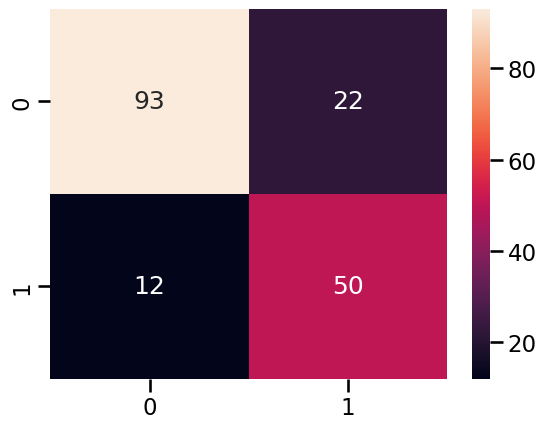

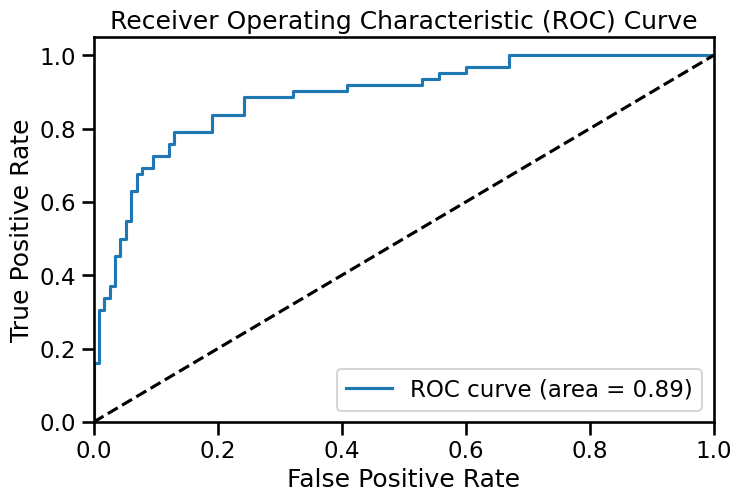

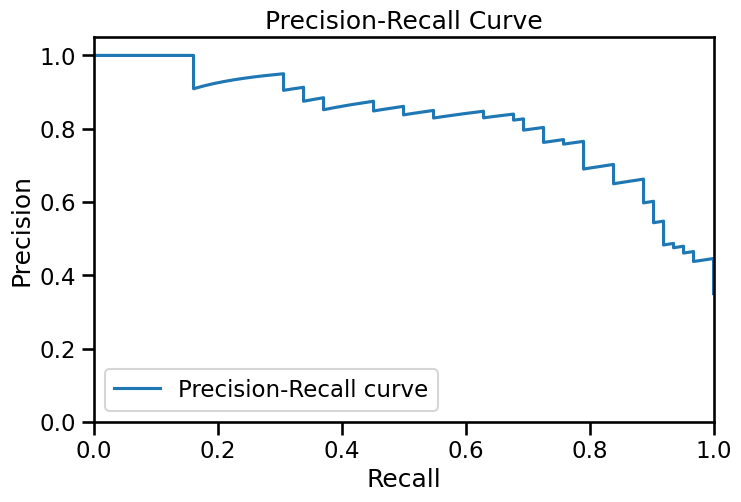

In [121]:
xgb_classifier_resampled = XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'auc', 
                                 learning_rate = 0.04212148052727849,
                                 max_depth = 10,
                                 #alpha = 17,
                                 gamma = 1.9782437016357846e-05,
                                 n_estimators = 435,                
                                 min_child_weight = 1,
                                 subsample = 0.9687327665689914,
                                 colsample_bytree = 0.7215321725151076,
                                 reg_alpha = 0.0006989466231533796,
                                 reg_lambda = 0.7249776408707947,
                                 scale_pos_weight = 1.853,
                                 #use_label_encoder = False,
                                 seed = 21).fit(X_resampled, y_resampled, eval_set = evalset_resampled, verbose = 0)

result_resampled = xgb_classifier_resampled.score(X_test_4, y_less_test)

y_pred_resampled = xgb_classifier_resampled.predict(X_test_4) 

y_pred_proba_resampled = xgb_classifier_resampled.predict_proba(X_test_4)

cm_resampled = confusion_matrix(y_less_test, y_pred_resampled)

sns.heatmap(cm_resampled, annot = True, fmt = 'd')

print()
print(classification_report(y_less_test, y_pred_resampled))

print()
print("Accuracy: {}".format(round(result_resampled, 4)))

print()
# Calculate log loss
log_loss_resampled = log_loss(y_less_test, y_pred_proba_resampled)

print("Log Loss: {}".format(round(log_loss_resampled, 4)))

print()

# Calculate ROC AUC
roc_auc_resampled = roc_auc_score(y_less_test, y_pred_proba_resampled[:, 1])

print("ROC AUC: {}".format(round(roc_auc_resampled, 4)))

print()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_less_test, y_pred_proba_resampled[:, 1])

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_less_test, y_pred_proba_resampled[:, 1])

# Define recall levels for interpolation
recall_levels = np.linspace(0, 1, 100)

# Interpolate precision values for each recall level
interp_precision = np.interp(recall_levels, recall[::-1], precision[::-1])

# Calculate AUPRC using the trapezoidal rule
auprc = np.trapz(interp_precision, recall_levels)

print("AUPRC: {}".format(round(auprc, 4)))

print()

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_less_test, y_pred_proba_resampled[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('pr_curve.png', dpi=300, bbox_inches='tight')
plt.show()